In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import torch

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, precision_score, recall_score, confusion_matrix

In [8]:
df = pd.read_csv('train.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())
print("\nDuplicated rows:", df.duplicated().sum())

Dataset Shape: (391650, 18)

Column Names and Data Types:
index                     int64
id                       object
g1                        int64
g2                        int64
relative_date_number      int64
y                       float64
x1                      float64
x2                      float64
x3                      float64
x4                      float64
x5                      float64
x6                      float64
x7                      float64
x8                      float64
x9                      float64
x10                     float64
x11                     float64
x12                     float64
dtype: object

First few rows:
   index                  id    g1     g2  relative_date_number    y   x1  \
0     70  1705.0;13221.0;1.0  1705  13221                     1  0.0  0.0   
1     71  1705.0;13221.0;2.0  1705  13221                     2  0.0  0.0   
2     72  1705.0;13221.0;3.0  1705  13221                     3  0.0  0.0   
3     73  1705.0;13221.0;4.

In [9]:
print("=== TARGET VARIABLE (y) ===")
print("Unique values:", sorted(df['y'].unique()))
print("Value counts:")
print(df['y'].value_counts())
print(f"Class imbalance ratio: {df['y'].value_counts()[0.0]/df['y'].value_counts()[1.0]:.2f}:1")

print("\n=== TEMPORAL STRUCTURE ===")
print("Date number range:", df['relative_date_number'].min(), "to", df['relative_date_number'].max())
print("Days per group (g1+g2 combo):")
time_per_group = df.groupby(['g1', 'g2'])['relative_date_number'].count().describe()
print(time_per_group)

print("\n=== GROUP STRUCTURE ===")
print("Unique g1 (parent groups):", df['g1'].nunique())
print("Unique g2 (child groups):", df['g2'].nunique())
print("Total g1-g2 combinations:", df.groupby(['g1', 'g2']).size().shape[0])
print("g1 per g2 ratio:", df.groupby('g2')['g1'].nunique().mean())

print("\n=== FEATURE STATISTICS (x1-x12) ===")
feature_cols = [f'x{i}' for i in range(1, 13)]
print(df[feature_cols].describe())

=== TARGET VARIABLE (y) ===
Unique values: [np.float64(0.0), np.float64(1.0)]
Value counts:
y
0.0    373480
1.0     18170
Name: count, dtype: int64
Class imbalance ratio: 20.55:1

=== TEMPORAL STRUCTURE ===
Date number range: 1 to 35
Days per group (g1+g2 combo):
count    11190.0
mean        35.0
std          0.0
min         35.0
25%         35.0
50%         35.0
75%         35.0
max         35.0
Name: relative_date_number, dtype: float64

=== GROUP STRUCTURE ===
Unique g1 (parent groups): 1093
Unique g2 (child groups): 11190
Total g1-g2 combinations: 11190
g1 per g2 ratio: 1.0

=== FEATURE STATISTICS (x1-x12) ===
                  x1             x2             x3             x4  \
count  391650.000000  391650.000000  391650.000000  391650.000000   
mean        0.000313       0.000605       0.001052       0.001322   
std         0.008093       0.008962       0.007231       0.012258   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

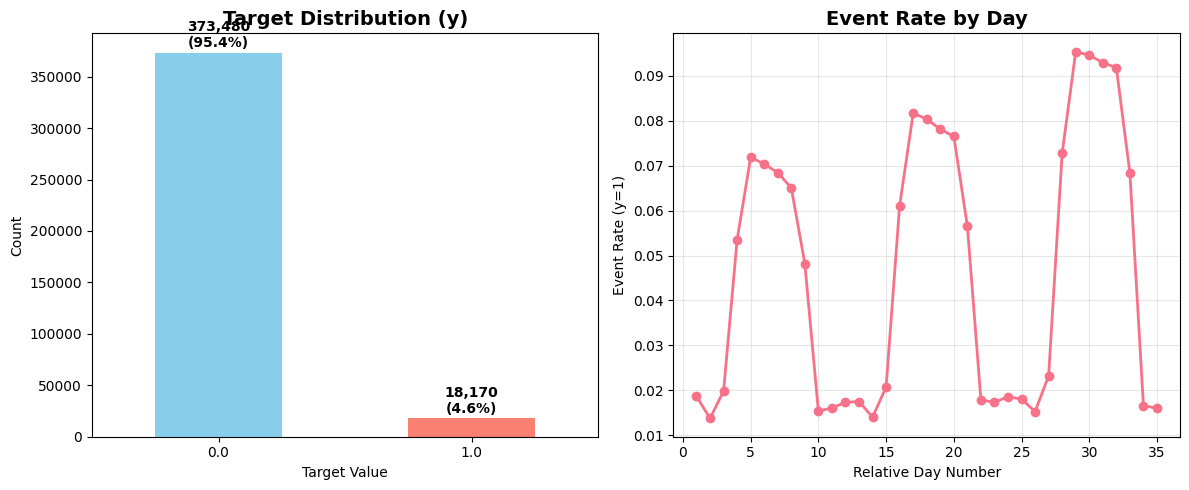

Target rate by day statistics:
count    35.000000
mean      0.046393
std       0.030298
min       0.013762
25%       0.017426
50%       0.048168
75%       0.072297
max       0.095353
Name: mean, dtype: float64


In [10]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['y'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Target Distribution (y)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target Value')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

total = len(df)
for i, v in enumerate(df['y'].value_counts().values):
    axes[0].text(i, v + 5000, f'{v:,}\n({v/total*100:.1f}%)', ha='center', fontweight='bold')

target_by_day = df.groupby('relative_date_number')['y'].agg(['count', 'sum', 'mean']).reset_index()
axes[1].plot(target_by_day['relative_date_number'], target_by_day['mean'], marker='o', linewidth=2, markersize=6)
axes[1].set_title('Event Rate by Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Relative Day Number')
axes[1].set_ylabel('Event Rate (y=1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Target rate by day statistics:")
print(target_by_day['mean'].describe())

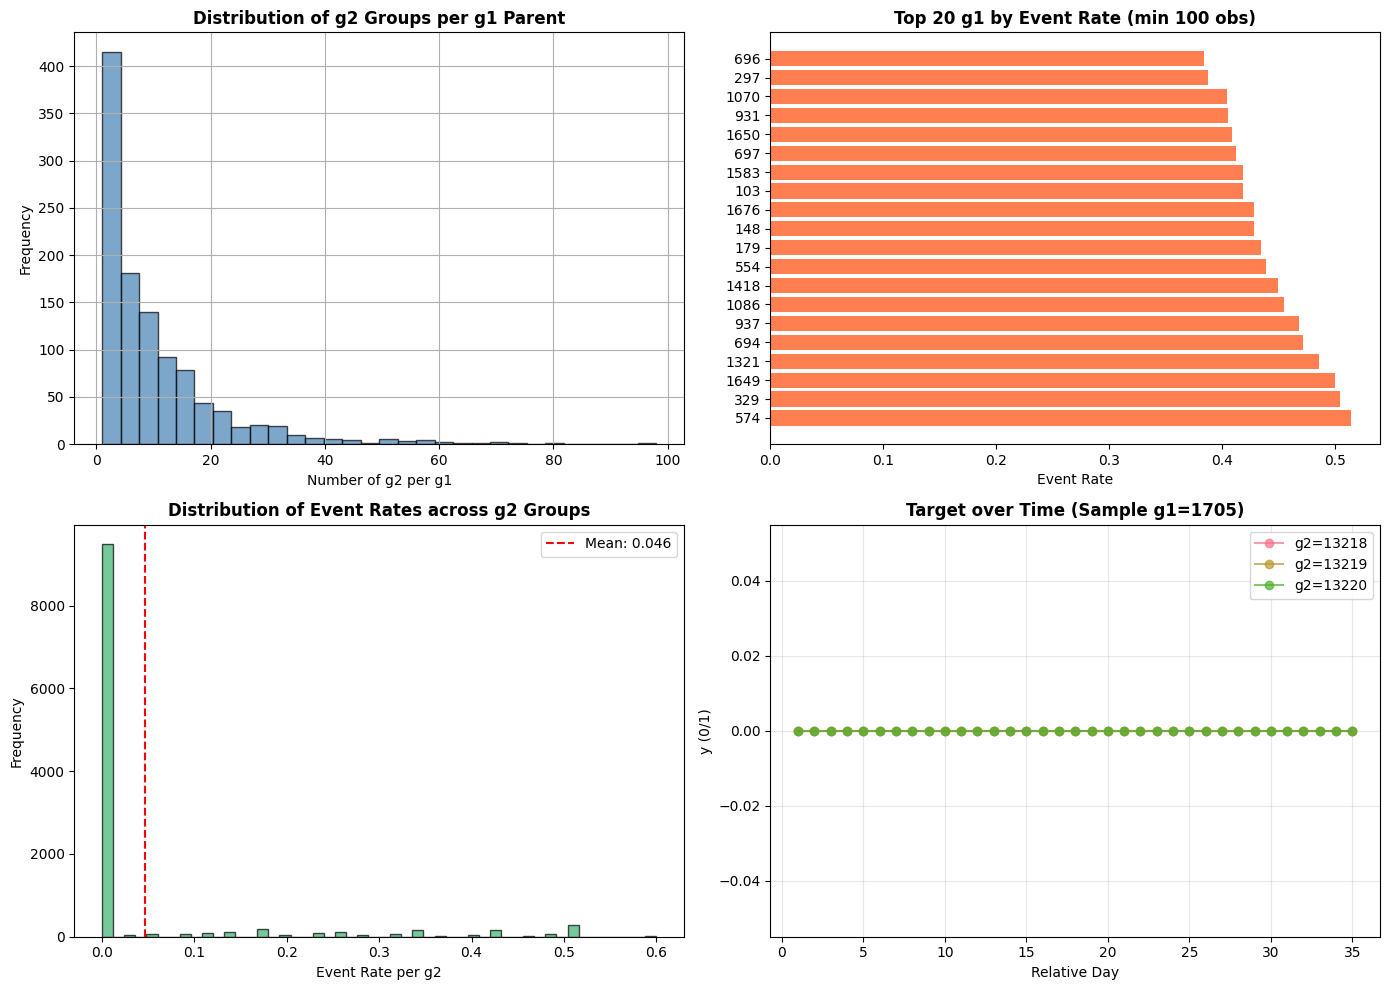

Groups per g1 statistics:
count    1093.000000
mean       10.237877
std        11.491363
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        98.000000
Name: g2, dtype: float64

G1 with most g2 children: 98 groups
G1 with least g2 children: 1 groups


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

groups_per_g1 = df.groupby('g1')['g2'].nunique()
groups_per_g1.hist(bins=30, ax=axes[0,0], color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of g2 Groups per g1 Parent', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Number of g2 per g1')
axes[0,0].set_ylabel('Frequency')

g1_stats = df.groupby('g1')['y'].agg(['count', 'mean']).reset_index()
g1_stats = g1_stats[g1_stats['count'] > 100].sort_values('mean', ascending=False).head(20)
axes[0,1].barh(g1_stats['g1'].astype(str), g1_stats['mean'], color='coral')
axes[0,1].set_title('Top 20 g1 by Event Rate (min 100 obs)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Event Rate')

g2_rates = df.groupby('g2')['y'].mean()
axes[1,0].hist(g2_rates, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1,0].set_title('Distribution of Event Rates across g2 Groups', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Event Rate per g2')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(g2_rates.mean(), color='red', linestyle='--', label=f'Mean: {g2_rates.mean():.3f}')
axes[1,0].legend()

sample_g1 = df['g1'].unique()[0]
sample_data = df[df['g1'] == sample_g1].sort_values(['g2', 'relative_date_number'])
sample_g2 = sample_data['g2'].unique()[:3]

for g2 in sample_g2:
    data = sample_data[sample_data['g2'] == g2]
    axes[1,1].plot(data['relative_date_number'], data['y'], marker='o', label=f'g2={g2}', alpha=0.7)
axes[1,1].set_title(f'Target over Time (Sample g1={sample_g1})', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Relative Day')
axes[1,1].set_ylabel('y (0/1)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Groups per g1 statistics:")
print(groups_per_g1.describe())
print(f"\nG1 with most g2 children: {groups_per_g1.max()} groups")
print(f"G1 with least g2 children: {groups_per_g1.min()} groups")

=== X12 ANALYSIS (Potentially Binary) ===
Unique values in x12: 2
Value counts for x12:
x12
0.0    110108
1.0    281542
Name: count, dtype: int64

Is x12 binary (0 or 1)? False
x12 = 0: 110108
x12 = 1: 0
Other values: 281542

Target rate by x12 value:
y         0.0       1.0
x12                    
0.0  1.000000  0.000000
1.0  0.935463  0.064537


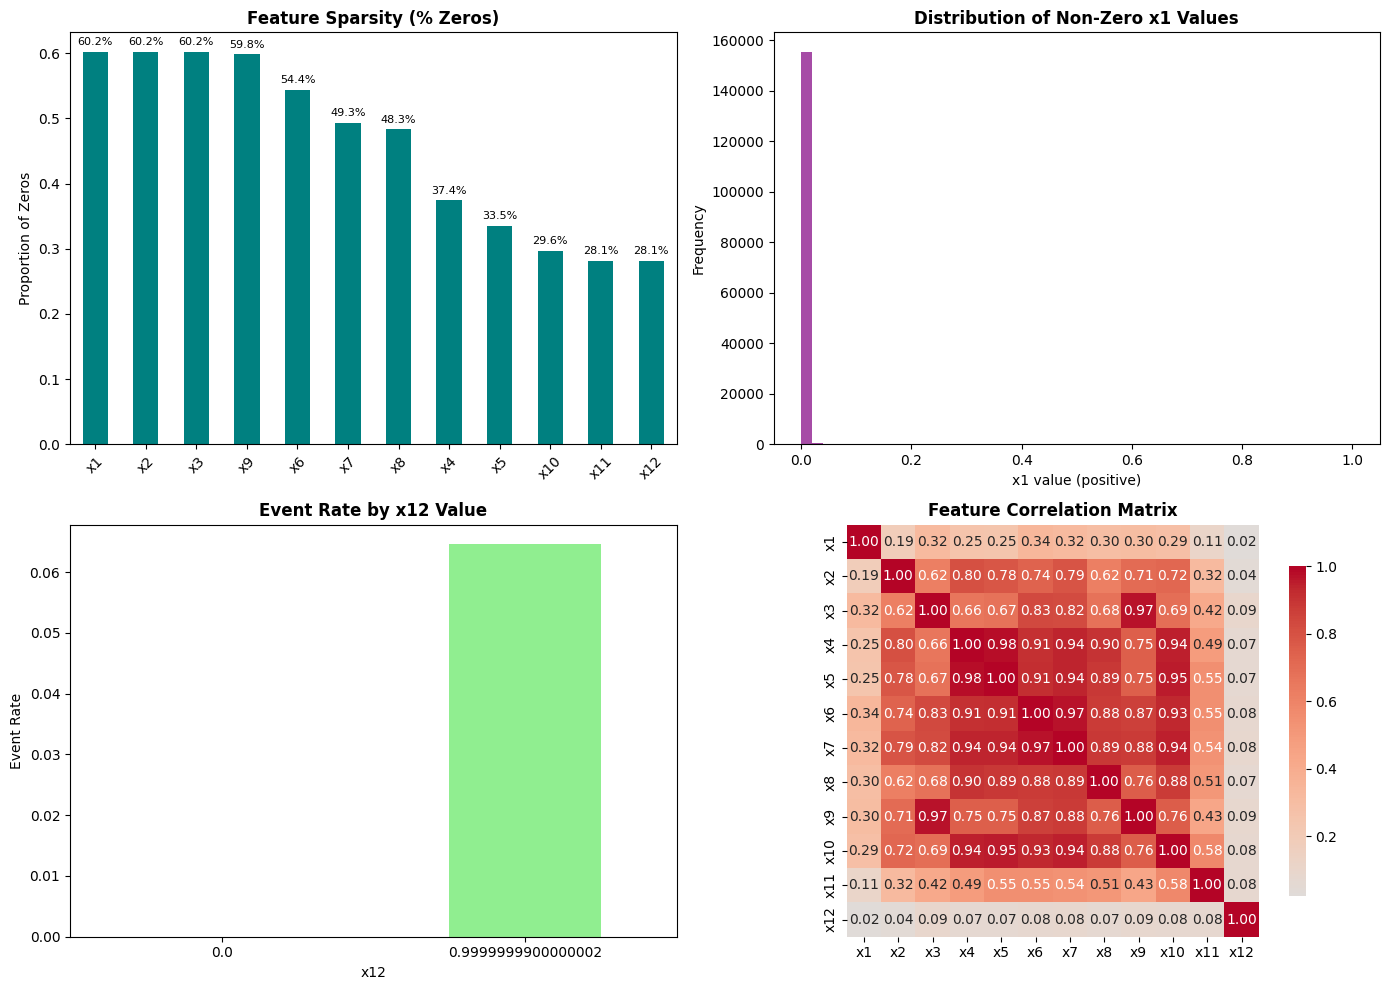

In [12]:
print("=== X12 ANALYSIS (Potentially Binary) ===")
print("Unique values in x12:", len(df['x12'].unique()))
print("Value counts for x12:")
print(df['x12'].value_counts().sort_index().head(10))

print(f"\nIs x12 binary (0 or 1)? {(df['x12'].isin([0.0, 1.0])).all()}")
print(f"x12 = 0: {(df['x12'] == 0.0).sum()}")
print(f"x12 = 1: {(df['x12'] == 1.0).sum()}")
print(f"Other values: {(~df['x12'].isin([0.0, 1.0])).sum()}")

crosstab = pd.crosstab(df['x12'], df['y'], normalize='index')
print("\nTarget rate by x12 value:")
print(crosstab)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sparsity = (df[feature_cols] == 0).mean().sort_values(ascending=False)
sparsity.plot(kind='bar', ax=axes[0,0], color='teal')
axes[0,0].set_title('Feature Sparsity (% Zeros)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Proportion of Zeros')
axes[0,0].tick_params(axis='x', rotation=45)

for i, v in enumerate(sparsity.values):
    axes[0,0].text(i, v + 0.01, f'{v:.1%}', ha='center', fontsize=8)

x1_nonzero = df[df['x1'] > 0]['x1']
axes[0,1].hist(x1_nonzero, bins=50, color='purple', alpha=0.7)
axes[0,1].set_title('Distribution of Non-Zero x1 Values', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('x1 value (positive)')
axes[0,1].set_ylabel('Frequency')

x12_target = df.groupby('x12')['y'].mean()
x12_target.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightgreen'])
axes[1,0].set_title('Event Rate by x12 Value', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Event Rate')
axes[1,0].tick_params(axis='x', rotation=0)

corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1,1], 
            square=True, cbar_kws={'shrink': 0.8})
axes[1,1].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

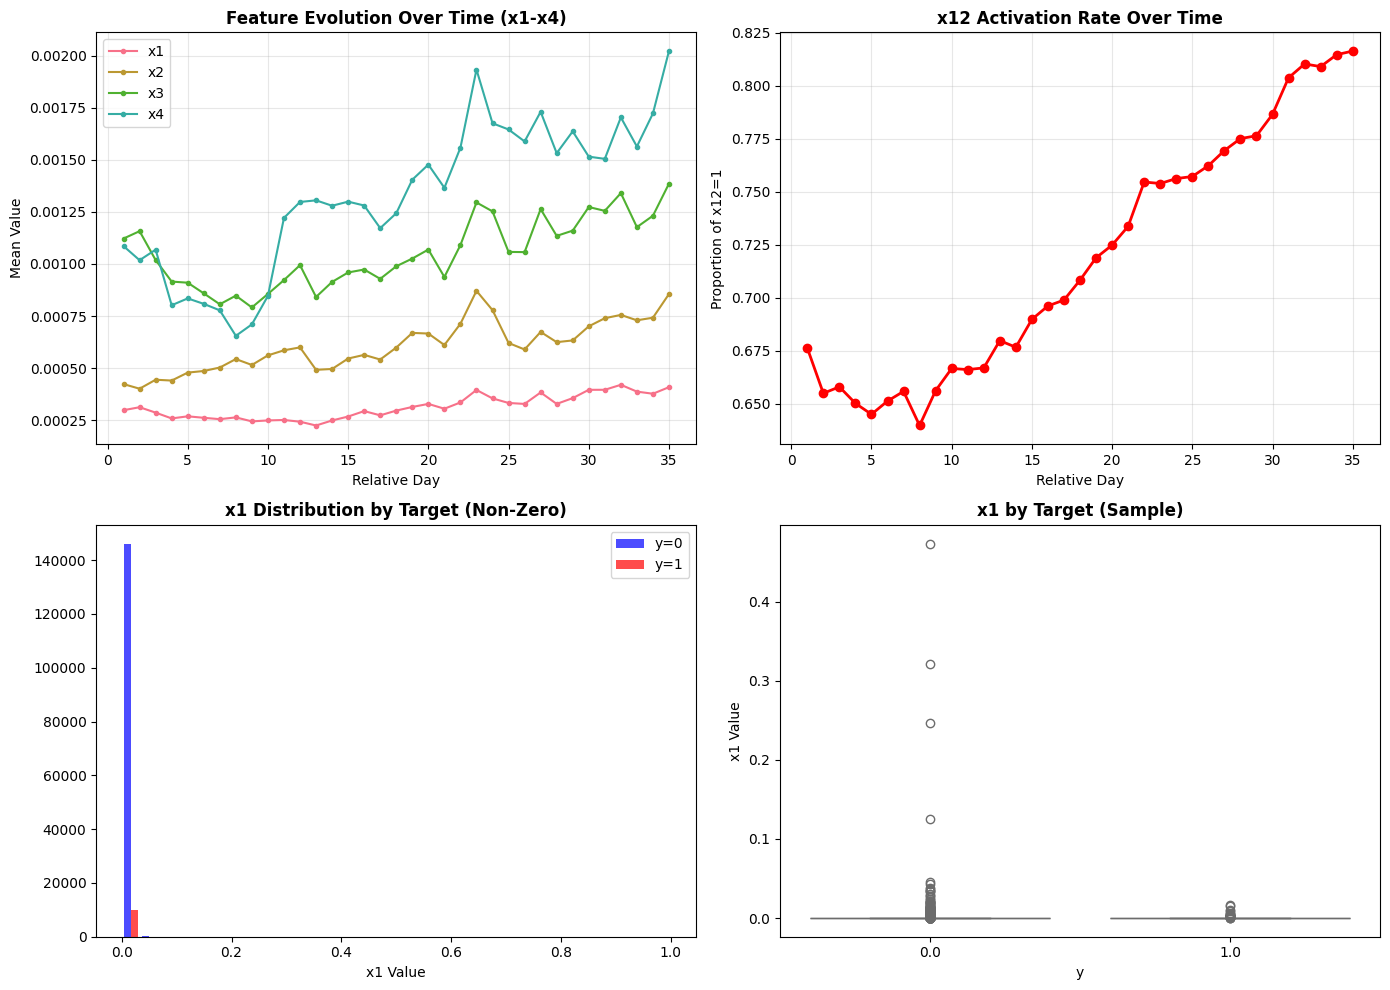

=== STATISTICAL TESTS ===

1. X12 vs Target (Chi-square):
   Chi-square: 7450.34, p-value: 0.00e+00
   Cramér's V: 0.1379

2. Feature means by target (y=0 vs y=1):
           x1        x2        x3        x4        x5        x6        x7  \
y                                                                           
0.0  0.000309  0.000564  0.001012  0.001266  0.001532  0.001457  0.001552   
1.0  0.000394  0.001466  0.001876  0.002482  0.002947  0.002266  0.002762   

           x8        x9       x10       x11       x12  
y                                                      
0.0  0.000956  0.001038  0.001987  0.001717  0.705184  
1.0  0.001175  0.002003  0.003431  0.001607  1.000000  

Difference (y=1 - y=0):
x12    0.294816
x10    0.001444
x5     0.001414
x4     0.001217
x7     0.001210
x9     0.000965
x2     0.000902
x3     0.000865
x6     0.000809
x8     0.000219
x1     0.000086
x11   -0.000110
dtype: float64


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

time_features = df.groupby('relative_date_number')[feature_cols].mean()
for col in ['x1', 'x2', 'x3', 'x4']:
    axes[0,0].plot(time_features.index, time_features[col], label=col, marker='o', markersize=3)
axes[0,0].set_title('Feature Evolution Over Time (x1-x4)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Relative Day')
axes[0,0].set_ylabel('Mean Value')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

x12_time = df.groupby('relative_date_number')['x12'].mean()
axes[0,1].plot(x12_time.index, x12_time.values, color='red', marker='o', linewidth=2)
axes[0,1].set_title('x12 Activation Rate Over Time', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Relative Day')
axes[0,1].set_ylabel('Proportion of x12=1')
axes[0,1].grid(True, alpha=0.3)

feat_target = df[df['x1'] > 0]
axes[1,0].hist([feat_target[feat_target['y']==0]['x1'], 
                feat_target[feat_target['y']==1]['x1']], 
               bins=30, alpha=0.7, label=['y=0', 'y=1'], color=['blue', 'red'])
axes[1,0].set_title('x1 Distribution by Target (Non-Zero)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('x1 Value')
axes[1,0].legend()

df_plot = df[df['x1'] > 0].sample(5000)
sns.boxplot(data=df_plot, x='y', y='x1', ax=axes[1,1])
axes[1,1].set_title('x1 by Target (Sample)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('x1 Value')

plt.tight_layout()
plt.show()

from scipy.stats import mannwhitneyu, chi2_contingency

print("=== STATISTICAL TESTS ===")
print("\n1. X12 vs Target (Chi-square):")
x12_binary = (df['x12'] > 0.5).astype(int)
chi2, p, dof, expected = chi2_contingency(pd.crosstab(x12_binary, df['y']))
print(f"   Chi-square: {chi2:.2f}, p-value: {p:.2e}")
print(f"   Cramér's V: {np.sqrt(chi2 / (len(df) * (min(2,2)-1))):.4f}")

print("\n2. Feature means by target (y=0 vs y=1):")
feature_means = df.groupby('y')[feature_cols].mean()
print(feature_means)
print("\nDifference (y=1 - y=0):")
print((feature_means.loc[1.0] - feature_means.loc[0.0]).sort_values(ascending=False))

In [16]:
print("=== X12-TARGET RELATIONSHIP DEEP DIVE ===")
y1_x12 = df[df['y'] == 1.0]['x12'].unique()
y0_x12 = df[df['y'] == 0.0]['x12'].unique()

print(f"Unique x12 values when y=1: {y1_x12}")
print(f"Unique x12 values when y=0: {sorted(y0_x12)}")

all_y1_have_x12_1 = (df[df['y'] == 1.0]['x12'] > 0.99).all()
print(f"\nAll y=1 cases have x12≈1: {all_y1_have_x12_1}")

y_rate_x12_0 = df[df['x12'] == 0.0]['y'].mean()
print(f"Y rate when x12=0: {y_rate_x12_0}")

y_rate_x12_1 = df[df['x12'] == 1.0]['y'].mean()
print(f"Y rate when x12=1: {y_rate_x12_1}")


=== X12-TARGET RELATIONSHIP DEEP DIVE ===
Unique x12 values when y=1: [0.99999999]
Unique x12 values when y=0: [np.float64(0.0), np.float64(0.9999999900000002)]

All y=1 cases have x12≈1: True
Y rate when x12=0: 0.0
Y rate when x12=1: nan


In [4]:
df_train = pd.read_csv('train.csv')

GROUP_COLS = ["g1", "g2"]
TIME_COL = "relative_date_number"
X_COLS = [f"x{i}" for i in range(1, 13)]

def new_features(df):
    df = df.copy()
    df = df.sort_values(GROUP_COLS + [TIME_COL]).reset_index(drop=True)
    
    new_cols = {}
    grp = df.groupby(GROUP_COLS)

    t = grp[TIME_COL].cumcount() + 1
    T = grp[TIME_COL].transform("max")
    new_cols["t"] = t
    new_cols["T"] = T
    new_cols["t_norm"] = t / T
    new_cols["t_from_end"] = T - t

    for k in [1, 2, 3]:
        new_cols[f"is_first_{k}"] = (t <= k).astype(int)
        new_cols[f"is_last_{k}"] = ((T - t) < k).astype(int)

    cycle_pos = df["relative_date_number"] % 12
    new_cols["is_cycle_start"] = (cycle_pos <= 2).astype(int)
    new_cols["is_cycle_end"] = (cycle_pos >= 10).astype(int)

    for col in X_COLS:
        lag1 = grp[col].shift(1)
        lag3 = grp[col].shift(3)

        new_cols[f"{col}_lag1"] = lag1
        new_cols[f"{col}_delta1"] = df[col] - lag1
        new_cols[f"{col}_lag3"] = lag3
        new_cols[f"{col}_delta3"] = df[col] - lag3

        new_cols[f"{col}_roll_mean3"] = grp[col].transform(lambda x: x.rolling(3, min_periods=1).mean())
        new_cols[f"{col}_roll_std3"] = grp[col].transform(lambda x: x.rolling(3, min_periods=1).std()).fillna(0)
        new_cols[f"{col}_roll_max3"] = grp[col].transform(lambda x: x.rolling(3, min_periods=1).max())

        new_cols[f"{col}_ratio_mean3"] = df[col] / (new_cols[f"{col}_roll_mean3"] + 1e-6)

        new_cols[f"{col}_cum_mean"] = grp[col].transform(lambda x: x.expanding().mean())
        new_cols[f"{col}_rank"] = grp[col].transform(lambda x: x.rank(pct=True))
        new_cols[f"{col}_rel_cum"] = df[col] / (new_cols[f"{col}_cum_mean"] + 1e-6)

        new_cols[f"{col}_nonzero"] = (df[col] > 0).astype(int)
        new_cols[f"{col}_increasing"] = (new_cols[f"{col}_delta1"] > 0).astype(int)

    df_features = pd.DataFrame(new_cols)
    df = pd.concat([df, df_features], axis=1)
    df.fillna(0, inplace=True)

    TOP = ["x3", "x5", "x7"]
    for i in range(len(TOP)):
        for j in range(i+1, len(TOP)):
            a, b = TOP[i], TOP[j]
            df[f"{a}_x_{b}"] = df[a] * df[b]
            df[f"d_{a}_x_d_{b}"] = df[f"{a}_delta1"] * df[f"{b}_delta1"]

    df["x12_onset"] = ((df["x12"] > 0) & (df.groupby(["g1", "g2"])["x12"].shift(1).fillna(0) == 0)).astype(np.int8)

    def run_length(s):
        out = np.zeros(len(s), dtype=int)
        cnt = 0
        for i, v in enumerate(s):
            if v > 0:
                cnt += 1
            else:
                cnt = 0
            out[i] = cnt
        return out

    df["x12_run"] = (df.groupby(["g1", "g2"])["x12"].transform(run_length))
    df["x12_run_norm"] = df["x12_run"] / (df.groupby(["g1","g2"])["x12_run"].transform("max") + 1e-6)
    df["x12_rate_3d"] = df.groupby(["g1","g2"])["x12"].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df["x12_rate_vs_hist"] = df["x12_rate_3d"] / (df["x12_cum_mean"] + 1e-6)
    df["x11_x12"] = df["x11"] * df["x12"]
    
    CYCLE = 12
    df["cycle_pos"] = (df["relative_date_number"] % CYCLE).astype(int)
    df["cycle_sin"] = np.sin(2 * np.pi * df["relative_date_number"] / CYCLE)
    df["cycle_cos"] = np.cos(2 * np.pi * df["relative_date_number"] / CYCLE)

    HIGH_RISK = {5, 6, 7, 8}
    df["cycle_high_risk"] = df["cycle_pos"].isin(HIGH_RISK).astype(int)

    def dist_to_peak(pos, peaks, cycle):
        return min(min((p - pos) % cycle, (pos - p) % cycle) for p in peaks)
    
    nonzero_cols = [f"{c}_nonzero" for c in X_COLS]
    inc_cols = [f"{c}_increasing" for c in X_COLS]
    
    df["num_nonzero"] = df[nonzero_cols].sum(axis=1)
    df["num_increasing"] = df[inc_cols].sum(axis=1)

    PEAKS = [5, 6, 7, 8]
    df["cycle_dist_to_peak"] = df["cycle_pos"].apply(lambda x: dist_to_peak(x, PEAKS, CYCLE)).astype(int)
    df["x12_cycle"] = df["x12"] * df["cycle_high_risk"]
    df["x12_onset_near_peak"] = ((df["x12_onset"] == 1) & (df["cycle_dist_to_peak"] <= 1)).astype(int)
    df["cycle_pos_norm"] = df["cycle_pos"] / CYCLE
    df["cycle_rising"] = (df.groupby(["g1","g2"])["cycle_sin"].diff().fillna(0) > 0).astype(int)

    df["x12_regime"] = ((df["x12_run"] >= 2).astype(int) +(df["x12_ratio_mean3"] >= 1.2).astype(int) +(df["x12_cycle"] > 0).astype(int))
    df["x12_continuing"] = ((df["x12_delta1"].abs() < 0.1) &(df["x12_lag1"] > 0)).astype(int)
    df["x12_continuing_roll3"] = (df.groupby(["g1","g2"])["x12_continuing"].rolling(3, min_periods=1).mean().reset_index(level=[0,1], drop=True))
    df["x12_divergence"] = (df["x12"] - df["x12_cum_mean"])
    df["x12_divergence_norm"] = df["x12_divergence"] / (df["x12_cum_mean"] + 1e-6)
    df["x12_dist_weighted"] = df["x12"] / (df["cycle_dist_to_peak"] + 1)
    df["event_eligible"] = ((df["t_norm"] >= 0.25) & (df["cycle_high_risk"] == 1) & (df["num_nonzero"] >= 3)).astype(int)

    df["fp_risk"] = ((df["x12"] > 0) &(df["x12_run"] <= 1) &(df["cycle_high_risk"] == 0)).astype(int)
    df["true_event_signature"] = ((df["x12_run"] >= 2) & (df["x12_ratio_mean3"] > 1.2) & (df["cycle_high_risk"] == 1)).astype(int)
    df["x12_persist_score"] = df["x12_run"] * df["x12_ratio_mean3"] * df["cycle_high_risk"]
    df["x12_regime_lag1"] = (df.groupby(["g1","g2"])["x12_regime"].shift(1).fillna(0))

    df["latent_event_state"] = ((df["x12_run"] >= 3) &(df["x12_ratio_mean3"] > 1.3) &(df["cycle_high_risk"] == 1)).astype(int)
    df["latent_event_memory"] = (df.groupby(["g1","g2"])["latent_event_state"].shift(1).fillna(0))
    df["fp_suppress"] = ((df["latent_event_memory"] == 1) &(df["x12_run"] <= 2)).astype(int)
    df["early_fp_risk"] = ((df["x12_run"] == 1) &(df["x12_ratio_mean3"] < 1.1) &(df["cycle_high_risk"] == 0)).astype(int)

    df["g1_peer_mean_past"] = (df.groupby(["g1", "g2"])["x12"].transform(lambda s: s.shift(1)))
    df["g1_peer_mean_past"] = (df.groupby("g1")["g1_peer_mean_past"].transform(lambda s: s.rolling(10, min_periods=3).mean()))
    df["x12_peer_anom"] = df["x12"] - df["g1_peer_mean_past"]

    return df

In [5]:
df_train = new_features(df_train)

In [6]:
gkf = GroupKFold(n_splits=5)

exclude = ['index','id', 'g1', 'g2', TIME_COL, 't', 'T', 'y', 'x12', 'x12_bin', 'num_nonzero', 'num_increasing']
features = [col for col in df_train.columns if col not in exclude]

def post_process_predictions(df, proba, threshold, low_threshold=0.15, min_run=2):
    df = df.copy()
    df["proba"] = proba

    df["pred_raw"] = (df["proba"] >= threshold).astype(int)

    grp = df.groupby(["g1", "g2"])

    df["pred_prev"] = grp["pred_raw"].shift(1).fillna(0)

    df["pred_pp"] = (
        (df["pred_raw"] == 1) &
        (
            (df["pred_prev"] == 1) |
            (df["cycle_high_risk"] == 1) |
            ((df["proba"] >= low_threshold) & (df["x12_run"] >= min_run)) |
            (df["t_from_end"] <= 1)
        )
    ).astype(int)

    return df["pred_pp"].values

oof_predictions = np.zeros(len(df_train))
fold_models = []
fold_thresholds = []
scores = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train['y'], groups=df_train["g1"].astype(str) + "_" + df_train["g2"].astype(str))):
    x_train, x_val = df_train[features].iloc[train_idx], df_train[features].iloc[val_idx]
    y_train, y_val = df_train['y'].iloc[train_idx], df_train['y'].iloc[val_idx]

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.06,
    'max_depth': 8,
    'min_child_weight': 20,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'gamma': 0.2,
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'max_delta_step': 1,
    'early_stopping_rounds' : 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
    
    model = xgb.XGBClassifier(**params, n_estimators=3000, random_state=42)

    model.fit(
        x_train, y_train,
        eval_set=[(x_val, y_val)],
        verbose=False
)

    val_pred = model.predict_proba(x_val)[:, 1]

    oof_predictions[val_idx] = val_pred
    thresholds = np.linspace(0.05, 0.7, 200)
    f1_scores = []
    for thr in thresholds:
        pp_pred = post_process_predictions(
            df_train.iloc[val_idx],
            val_pred,
            threshold=thr
        )
        f1_scores.append(f1_score(y_val, pp_pred))
    best_thr = thresholds[np.argmax(f1_scores)]
    fold_f1 = max(f1_scores)

    fold_models.append(model)
    fold_thresholds.append(best_thr)
    scores.append(fold_f1)

    print(f"Fold {fold + 1} F1: {fold_f1:.4f}, Best threshold: {best_thr:.3f}")

print(f"\n========== CV Results ==========")
print(f"Mean F1: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
print(f"Thresholds per fold: {[f'{t:.3f}' for t in fold_thresholds]}")

global_thresholds = np.linspace(0.1, 0.9, 100)
global_f1_scores = []
for thr in global_thresholds:
    pp_oof = post_process_predictions(
        df_train,
        oof_predictions,
        threshold=thr
    )
    global_f1_scores.append(f1_score(df_train["y"], pp_oof))

global_best_thr = global_thresholds[np.argmax(global_f1_scores)]
print(f"OOF F1 (post-processed): {max(global_f1_scores):.4f}")

d:\Code\projects\21vek test\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [14:34:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Fold 1 F1: 0.4244, Best threshold: 0.471
Fold 2 F1: 0.4356, Best threshold: 0.380
Fold 3 F1: 0.4485, Best threshold: 0.432
Fold 4 F1: 0.4424, Best threshold: 0.403
Fold 5 F1: 0.4428, Best threshold: 0.399

========== CV Results ==========
Mean F1: 0.4388 (+/- 0.0082)
Thresholds per fold: ['0.471', '0.380', '0.432', '0.403', '0.399']
OOF F1 (post-processed): 0.4376


In [7]:
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance.head(15))
print(importance.tail(10))

# redundant_features_1 = importance[importance['importance'] <= 0.0005]['feature'].tolist()
# redundant_features_2 = importance[importance['importance'] <= 0.0005]['feature'].tolist()

                feature  importance
175         x12_nonzero    0.330427
162         x11_nonzero    0.270576
171     x12_ratio_mean3    0.088723
203   x12_dist_weighted    0.076333
10                  x11    0.012515
197        cycle_rising    0.011799
193  cycle_dist_to_peak    0.004156
174         x12_rel_cum    0.003532
183           x12_onset    0.002189
147            x10_rank    0.002131
185        x12_run_norm    0.002116
23              x1_lag3    0.001920
19       is_cycle_start    0.001724
42          x2_cum_mean    0.001707
141          x10_delta3    0.001698
                 feature  importance
165           x12_delta1    0.000330
32            x1_nonzero    0.000314
15            is_first_2    0.000301
212        early_fp_risk    0.000179
58            x3_nonzero    0.000000
45            x2_nonzero    0.000000
170        x12_roll_max3    0.000000
209   latent_event_state    0.000000
210  latent_event_memory    0.000000
211          fp_suppress    0.000000


In [ ]:
df_test = pd.read_csv('test.csv')
df_test = new_features(df_test)

test_proba = np.zeros(len(df_test))

for model in fold_models:
    test_proba += model.predict_proba(df_test[features])[:, 1] / len(fold_models)

test_predictions = post_process_predictions(
    df_test,
    test_proba,
    threshold=global_best_thr
)

In [ ]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'y': test_predictions
})
submission.to_csv('submission.csv', index=False)